# Experiment: Semantic Search

## Step,Action,Technical Concept
1. You turn your entire library of documents into vectors. **->** Indexing
2. You store these vectors in a specialized index. **->** Vector Embeddings
3. "A user submits a query, which is also turned into a vector." **->** Query Encoding
4. "The system finds the ""nearest neighbors"" to that query vector." **->** (k-NN)
5. The system returns the documents associated with those neighbors. **->** Ranked Results

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

In [ ]:
# --- PHASE 1: INITIALIZATION ---
# Load the model (The "Encoder")
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# --- PHASE 2: VECTOR EMBEDDING ---
# We take our raw text data and "translate" it into a list of numbers (vectors).
raw_documents = [
    "The North Star, also known as Polaris, is in the northern sky.",
    "Baking bread requires flour, water, and yeast.",
    "The Eiffel Tower is a wrought-iron lattice tower in Paris, France."
]

# This is the actual embedding step
vector_1 = model.encode(raw_documents[0])
vector_2 = model.encode(raw_documents[1])
vector_3 = model.encode(raw_documents[2])

In [ ]:
print('raw vector', vector_1.shape)

raw vector (384,)


In [ ]:
# --- PHASE 3: INDEXING ---
# We organize these individual vectors into a single Matrix (The Index).
# This allows us to perform mathematical operations on all documents at once.
document_index = np.array([vector_1, vector_2, vector_3])

In [ ]:
# --- PHASE 4: QUERY ENCODING ---
# A user asks a question. We must turn it into a vector using the SAME model.
# user_query = "What is the location of the French landmark?" # Top Result: The Eiffel Tower is a wrought-iron lattice tower in Paris, France. Confidence Score: 0.3885
user_query = "Where is Eifel Tower?" # Top Result: The Eiffel Tower is a wrought-iron lattice tower in Paris, France. Confidence Score: 0.5780

query_vector = model.encode(user_query)

In [ ]:
# --- PHASE 5: KNN & RANKED RESULTS ---
# Step A: Calculate Cosine Similarity (Math)
# We find the 'distance' between the query_vector and every vector in the index.
dot_product = np.dot(document_index, query_vector)
norms = np.linalg.norm(document_index, axis=1) * np.linalg.norm(query_vector)
similarity_scores = dot_product / norms

# Step B: Ranking (Sorting)
# We find the index of the highest score.
best_match_idx = np.argmax(similarity_scores)

print(f"\nQuery: {user_query}")
print(f"Top Result: {raw_documents[best_match_idx]}")
print(f"Confidence Score: {similarity_scores[best_match_idx]:.4f}")


Query: Where is Eifel Tower?
Top Result: The Eiffel Tower is a wrought-iron lattice tower in Paris, France.
Confidence Score: 0.5780


In [ ]:
## Approach 2

from sentence_transformers import SentenceTransformer
import numpy as np

# PHASE 1
model = SentenceTransformer('all-MiniLM-L6-v2')

# PHASE 2 & 3: Storing with Metadata
# We create a list of dictionaries to keep text and vectors linked
knowledge_base = [
    {"id": 1, "text": "The North Star is Polaris.", "cat": "Space"},
    {"id": 5, "text": "Sigma Octantis is the closest southern star.", "cat": "Space"},
    {"id": 2, "text": "Baking bread needs yeast.", "cat": "Cooking"},
    {"id": 3, "text": "Paris is home to the Eiffel Tower.", "cat": "Travel"},
    {"id": 4, "text": "Paris is known for perfumes.", "cat": "Lifestyle"}
]

# Create the index (just the numbers)
# We map the index position [0, 1, 2] to our knowledge_base list
vectors = [model.encode(item["text"]) for item in knowledge_base]
document_index = np.array(vectors)

# PHASE 4: Query
query_text = "Which star is in the north?" # Found Match: The North Star is Polaris. Category: Space | Score: 0.7875
#query_text = "Tell me a southern star?"     # Found Match: Sigma Octantis is the closest southern star. Category: Space | Score: 0.6825
query_vec = model.encode(query_text)

# PHASE 5: Ranking
scores = np.dot(document_index, query_vec) / (np.linalg.norm(document_index, axis=1) * np.linalg.norm(query_vec))
best_idx = np.argmax(scores)

# THE PAYOFF: Using the index to get the Metadata
result = knowledge_base[best_idx]
print(f"Found Match: {result['text']}")
print(f"Category: {result['cat']} | Score: {scores[best_idx]:.4f}")

Found Match: The North Star is Polaris.
Category: Space | Score: 0.7875


In [ ]:
# Compare the tokenisation of the two LLMs


from transformers import AutoTokenizer

# Let's compare two different "Brains" (Tokenizers)
# 1. MiniLM (What we used before)
# 2. BERT (The classic academic encoder)
tokenizer_mini = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "Apple hypothyroidism indemnification"

# Function to show tokens
def show_tokens(tokenizer, text, name):
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    print(f"--- {name} ---")
    print(f"Tokens: {tokens}")
    print(f"IDs:    {ids}\n")

show_tokens(tokenizer_mini, text, "MiniLM")
show_tokens(tokenizer_bert, text, "BERT")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

--- MiniLM ---
Tokens: ['apple', 'h', '##yp', '##oth', '##yr', '##oid', '##ism', 'ind', '##em', '##ni', '##fication']
IDs:    [6207, 1044, 22571, 14573, 12541, 9314, 2964, 27427, 6633, 3490, 10803]

--- BERT ---
Tokens: ['apple', 'h', '##yp', '##oth', '##yr', '##oid', '##ism', 'ind', '##em', '##ni', '##fication']
IDs:    [6207, 1044, 22571, 14573, 12541, 9314, 2964, 27427, 6633, 3490, 10803]



## Decode the token and tokenisation IDs to get the sentence back

In [ ]:


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
#ids = [6207, 1044, 22571, 14573, 12541, 9314, 2964] # Your IDs from the output # apple hypothyroidism
#ids = [6207, 1044, 22571, 14573, 12541, 9314, 2964, 27427, 6633, 3490, 10803] # Reconstructed: apple hypothyroidism indemnification

# This turns IDs back into a human string
clean_text = tokenizer.decode(ids)

print(f"Original IDs: {ids}")
print(f"Reconstructed: {clean_text}")
# Result: "apple hypothyroidism"

NameError: name 'ids' is not defined

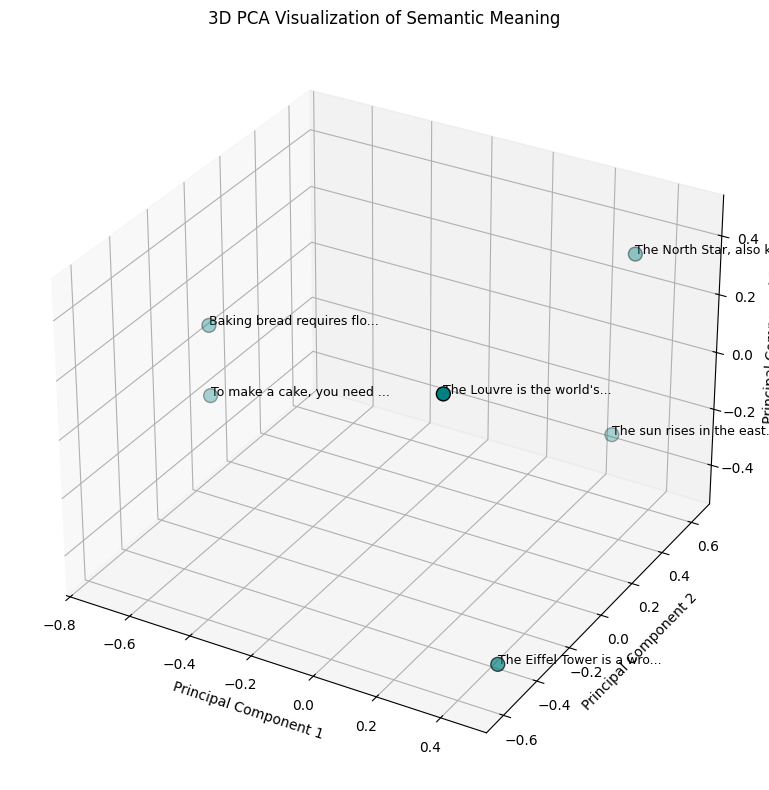

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np

# 1. Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Data with clear "categories" to show clustering
sentences = [
    "Baking bread requires flour, water, and yeast.",
    "To make a cake, you need sugar and eggs.",
    "The Eiffel Tower is a wrought-iron lattice tower in Paris.",
    "The Louvre is the world's largest art museum in Paris.",
    "The North Star, also known as Polaris, is in the northern sky.",
    "The sun rises in the east and sets in the west."
]

# 3. Create the 384-dimension embeddings
embeddings = model.encode(sentences)

# 4. Reduce dimensions from 384 down to 3
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)

# 5. Create the 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = reduced[:, 0], reduced[:, 1], reduced[:, 2]

# Plot the points
ax.scatter(x, y, z, c='teal', s=100, edgecolors='black')

# Add labels to each point
for i, txt in enumerate(sentences):
    # Truncate text for readability
    label = (txt[:25] + '...') if len(txt) > 25 else txt
    ax.text(x[i], y[i], z[i], label, size=9, zorder=1, color='k')

ax.set_title("3D PCA Visualization of Semantic Meaning")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.tight_layout()
plt.show()

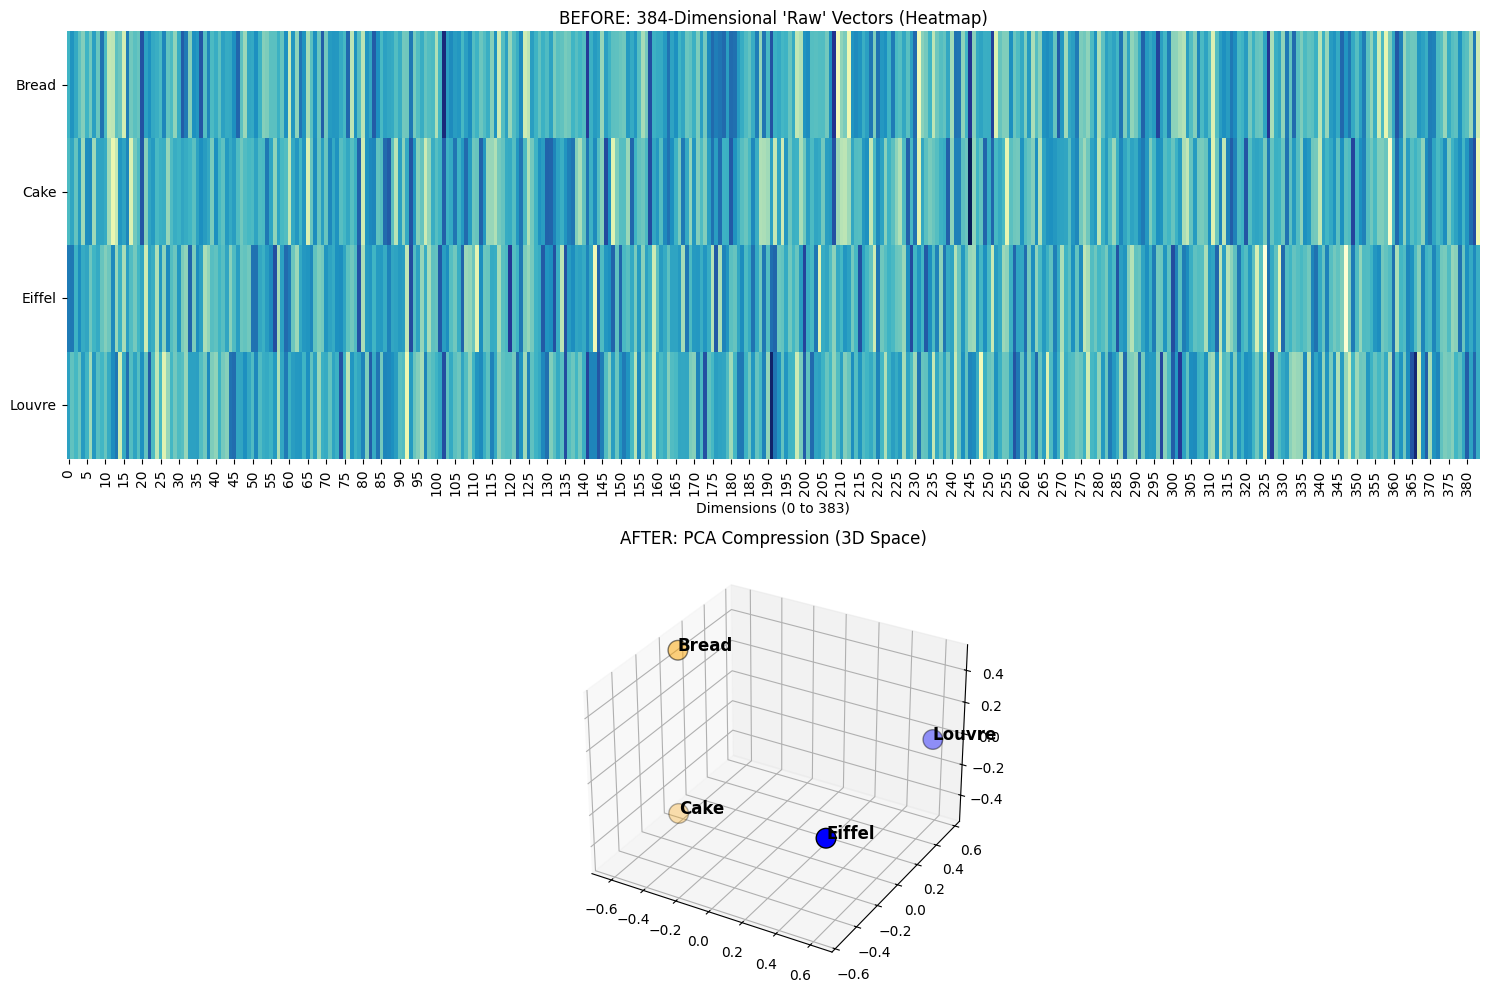

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# 1. Setup Data
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = [
    "Baking bread requires flour, water, and yeast.",
    "To make a cake, you need sugar and eggs.",
    "The Eiffel Tower is a wrought-iron lattice tower in Paris.",
    "The Louvre is the world's largest art museum in Paris."
]
embeddings = model.encode(sentences)

# 2. Create the Figure with two parts (Subplots)
fig = plt.figure(figsize=(15, 10))

# --- PART 1: THE "BEFORE" (Heatmap of 384 Dimensions) ---
ax1 = fig.add_subplot(2, 1, 1)
sns.heatmap(embeddings, cmap="YlGnBu", cbar=False, ax=ax1)
ax1.set_title("BEFORE: 384-Dimensional 'Raw' Vectors (Heatmap)")
ax1.set_yticklabels(["Bread", "Cake", "Eiffel", "Louvre"], rotation=0)
ax1.set_xlabel("Dimensions (0 to 383)")

# --- PART 2: THE "AFTER" (3D PCA Projection) ---
# We reduce the 384 dimensions down to 3
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)

ax2 = fig.add_subplot(2, 1, 2, projection='3d')
x, y, z = reduced[:, 0], reduced[:, 1], reduced[:, 2]

# Plot the points
colors = ['orange', 'orange', 'blue', 'blue'] # Grouping by color
ax2.scatter(x, y, z, c=colors, s=200, edgecolors='black')

for i, txt in enumerate(["Bread", "Cake", "Eiffel", "Louvre"]):
    ax2.text(x[i], y[i], z[i], txt, size=12, fontweight='bold')

ax2.set_title("AFTER: PCA Compression (3D Space)")

plt.tight_layout()
plt.show()

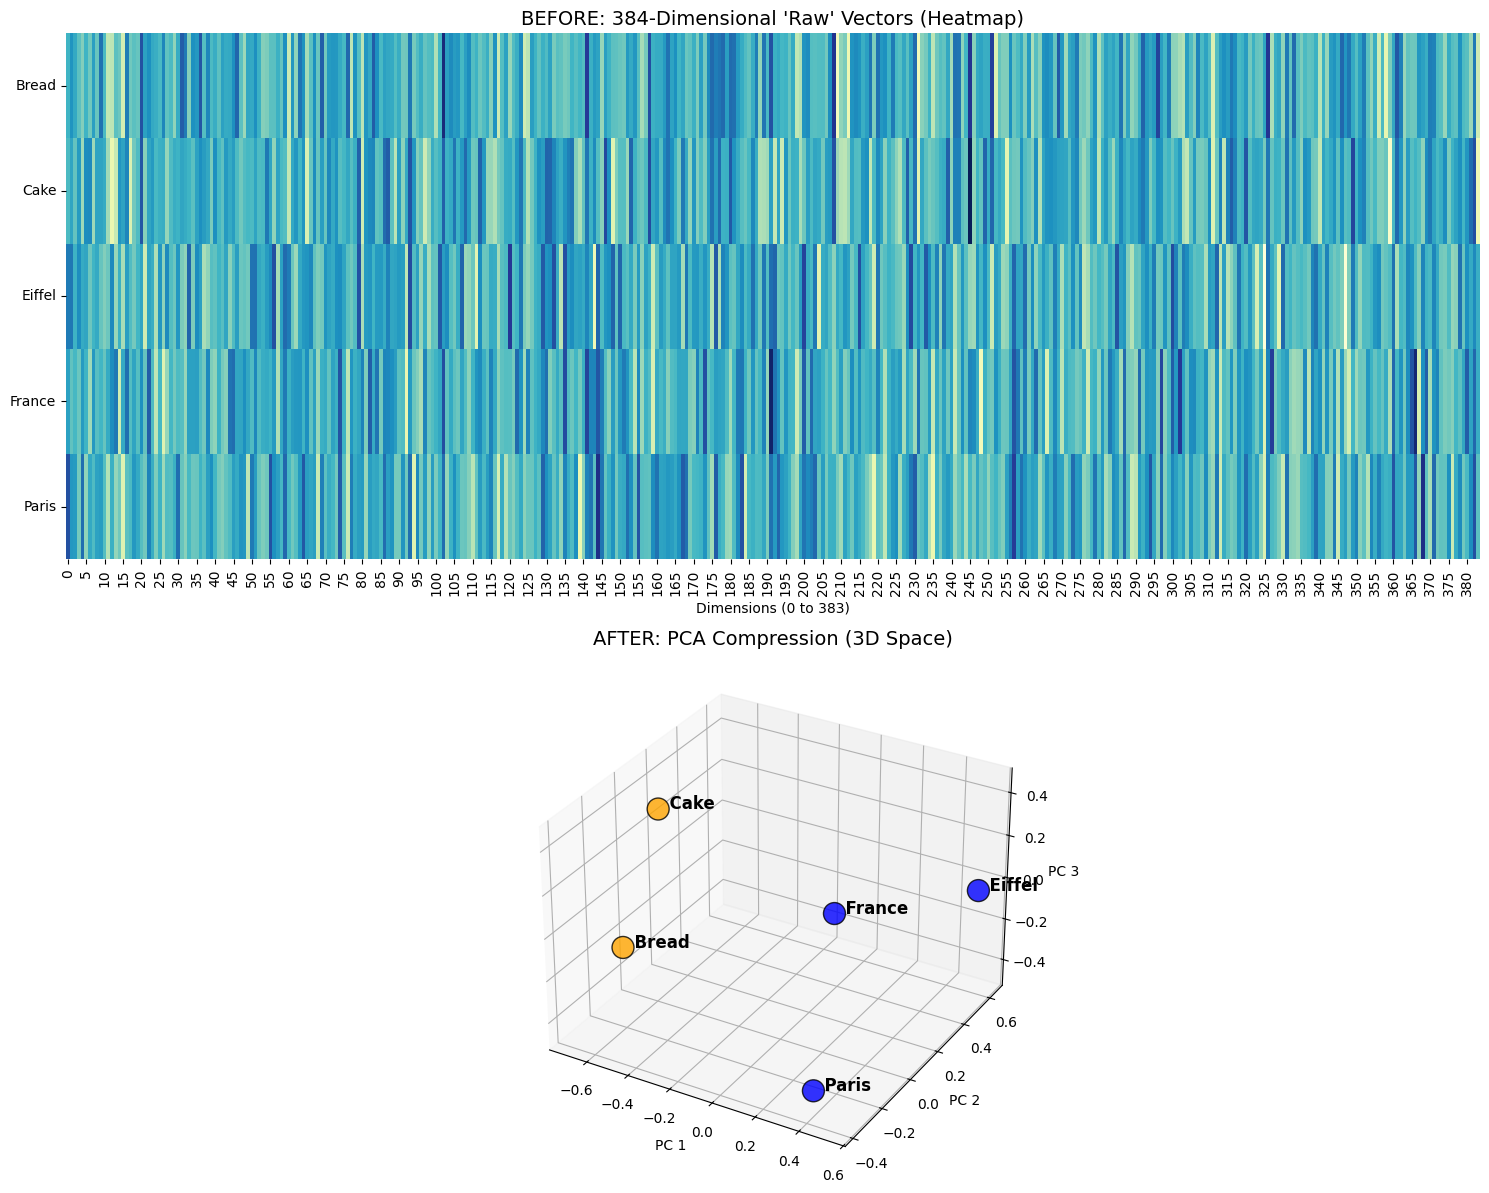

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# 1. Setup Data - We add the single word "Paris" to see its relationship
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = [
    "Baking bread requires flour, water, and yeast.",
    "To make a cake, you need sugar and eggs.",
    "The Eiffel Tower is a wrought-iron lattice tower in Paris.",
    "The Louvre is the world's largest art museum in Paris.",
    "Paris is capital of france"
]
labels = ["Bread", "Cake", "Eiffel", "France", "Paris"]
embeddings = model.encode(sentences)

# 2. Create the Figure with two subplots
fig = plt.figure(figsize=(15, 12))

# --- PART 1: THE "BEFORE" (Heatmap of 384 Dimensions) ---
ax1 = fig.add_subplot(2, 1, 1)
sns.heatmap(embeddings, cmap="YlGnBu", cbar=False, ax=ax1)
ax1.set_title("BEFORE: 384-Dimensional 'Raw' Vectors (Heatmap)", fontsize=14)
ax1.set_yticklabels(labels, rotation=0)
ax1.set_xlabel("Dimensions (0 to 383)")

# --- PART 2: THE "AFTER" (3D PCA Projection) ---
# Reduce from 384 dimensions down to 3
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)

ax2 = fig.add_subplot(2, 1, 2, projection='3d')
x, y, z = reduced[:, 0], reduced[:, 1], reduced[:, 2]

# Categorical colors: Food (Orange), Paris Landmarks (Blue), Core Concept (Red)
colors = ['orange', 'orange', 'blue', 'blue', 'red']
ax2.scatter(x, y, z, c=colors, s=250, edgecolors='black', alpha=0.8)

# Add labels to the 3D points
for i, txt in enumerate(labels):
    ax2.text(x[i], y[i], z[i], f"  {txt}", size=12, fontweight='bold')

ax2.set_title("AFTER: PCA Compression (3D Space)", fontsize=14)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")

plt.tight_layout()
plt.show()